In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MaxAbsScaler
from tqdm import tqdm


def generate_dataset(dataset: pd.DataFrame, n: int = 224, m: int = 224, step_n: int = 224, step_m: int = 224, info=True, scale: bool = True):
    """
    Create dataset from raw df with sliding window. MinMaxScale numbers
    :param dataset: df
    :param n: height window size
    :param m: width window size
    :param step_n: height window step
    :param step_m: width window step
    :param info: if True -> prints sizes of data in GBs
    :return: pair of scaled X and Y and true shape
    """
    matrix_numbers = np.array(dataset['numbers'].values.tolist(), dtype=float)
    matrix_target = np.array(dataset['target'].values.tolist(), dtype=float)
    mkm_0 = matrix_numbers.shape[0]
    mkm_1 = matrix_numbers.shape[1]
    matrix_numbers = matrix_numbers[:-(mkm_0 % n), :-(mkm_1 % m)]
    matrix_target = matrix_target[:-(mkm_0 % n), :-(mkm_1 % m)]

    if scale:
        scaler = MaxAbsScaler()
        matrix_numbers = scaler.fit_transform(matrix_numbers)
        print(matrix_numbers.min(), matrix_numbers.max())
    if info:
        print('Memory size was:', matrix_numbers.nbytes / 2**30, 'GB, ', matrix_target.nbytes / 2**30, 'GB')

    x = []
    counter_0 = 0
    for i in tqdm(range(0, matrix_numbers.shape[0] - n + 1, step_n)):
        counter_0 += 1
        counter_1 = 0
        for j in range(0, matrix_numbers.shape[1] - m + 1, step_m):
            counter_1 += 1
            window = matrix_numbers[i:i + n, j:j + m]
            x.append(window)
    x = np.array(x, dtype=float)

    y = []
    for i in tqdm(range(0, matrix_target.shape[0] - n + 1, step_n)):
        for j in range(0, matrix_target.shape[1] - m + 1, step_m):
            window = matrix_target[i:i + n, j:j + m]
            y.append(window)
    y = np.array(y, dtype=float)

    if info:
        print('Memory size X Y:', x.nbytes / 2**30, 'GB, ', y.nbytes / 2**30, 'GB')
    return x, y, (counter_0, counter_1)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Загрузка и предобработка набора данных
path_to_file = "/content/drive/MyDrive/new_datasets/part2.csv"
df = pd.read_csv(path_to_file)
df['numbers'] = df['numbers'].map(lambda x: list(map(float, x[1:-1].split(','))))
df['target'] = df['target'].map(lambda x: list(map(float, x.split(','))))
X, Y, true_raw_shape = generate_dataset(df, info=True)
del df

print(X.shape, Y.shape)

# Разделение на обучающую и тестовую выборки
def train_test_split(X, Y, test_size=0.2):
    assert 0 < test_size < 1
    n = int(X.shape[0] * (1-test_size))
    return X[:n], X[n:], Y[:n], Y[n:]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4)

del X
del Y

-1.0 1.0
Memory size was: 0.112152099609375 GB,  0.112152099609375 GB


100%|██████████| 3/3 [00:00<00:00, 940.71it/s]


Memory size X Y: 0.112152099609375 GB,  0.112152099609375 GB
(300, 224, 224) (300, 224, 224)


In [3]:
import torch
from torchvision import transforms

x_train_expanded = np.expand_dims(x_train, axis=1)
x_train_rgb = np.repeat(x_train_expanded, 3, axis=1)

to_tensor_transform = transforms.Compose([
    transforms.ToTensor()
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train_rgb_tensor_normalized = torch.stack([to_tensor_transform(img) for img in x_train_rgb]).double()
x_train_rgb_tensor_normalized = x_train_rgb_tensor_normalized.permute(0, 2, 3, 1).to(device)


In [4]:
x_train_rgb_tensor_normalized.shape

torch.Size([180, 3, 224, 224])

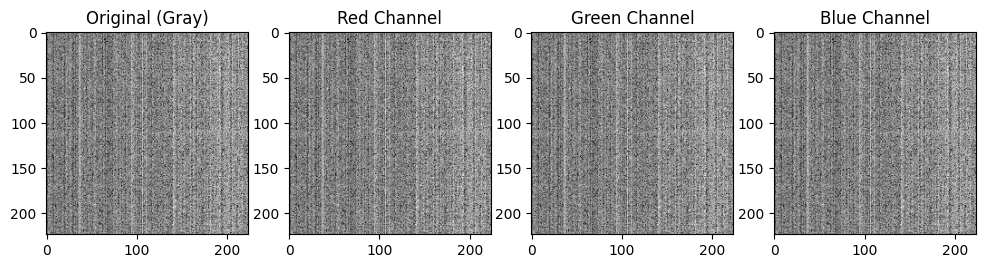

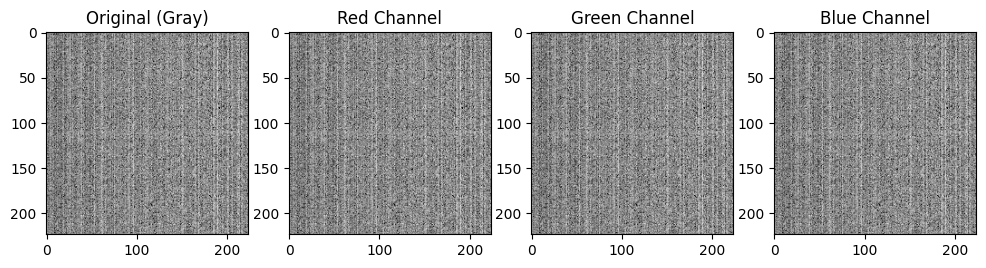

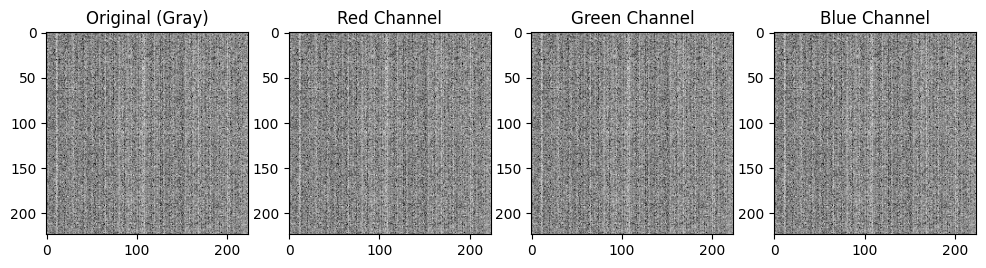

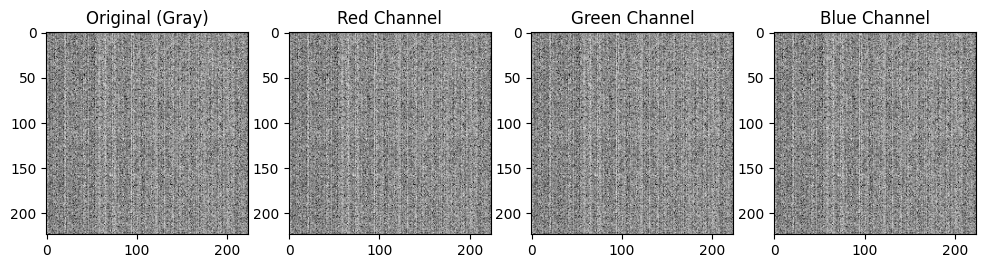

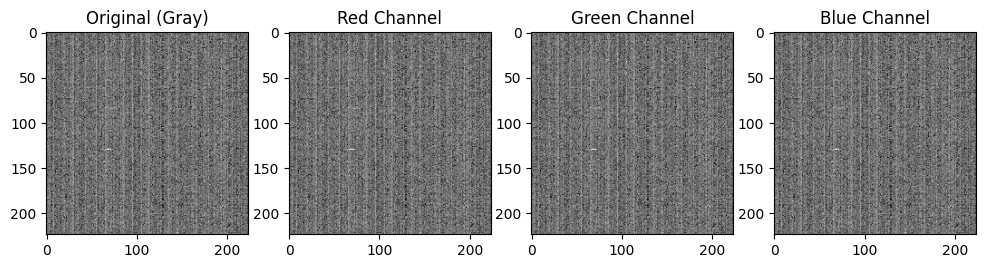

In [5]:
import matplotlib.pyplot as plt

# Предполагая, что x_train - это массив данных с одноканальными изображениями
# Размерность x_train: (180, 224, 224)

# Выбор нескольких изображений для визуализации
num_images_to_display = 5

# Визуализация
for i in range(num_images_to_display):
    # Извлечение i-го одноканального изображения
    grayscale_image = x_train[i]

    # Извлечение i-го трехканального изображения
    rgb_image_normalized = x_train_rgb_tensor_normalized[i]

    # Разделение каналов
    red_channel = rgb_image_normalized[0]
    green_channel = rgb_image_normalized[1]
    blue_channel = rgb_image_normalized[2]

    # Визуализация
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(grayscale_image, cmap='gray')  # Оригинальное одноканальное изображение
    plt.title('Original (Gray)')

    plt.subplot(1, 4, 2)
    plt.imshow(red_channel, cmap='gray')  # Красный канал
    plt.title('Red Channel')

    plt.subplot(1, 4, 3)
    plt.imshow(green_channel, cmap='gray')  # Зеленый канал
    plt.title('Green Channel')

    plt.subplot(1, 4, 4)
    plt.imshow(blue_channel, cmap='gray')  # Синий канал
    plt.title('Blue Channel')

    plt.show()


In [6]:
from torch.utils.data import DataLoader, TensorDataset
y_train_tensor = torch.from_numpy(y_train).long()
x_train_rgb_tensor_normalized = x_train_rgb_tensor_normalized.double()
train_dataset = TensorDataset(x_train_rgb_tensor_normalized, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [7]:
y_train_tensor.shape

torch.Size([180, 224, 224])

In [8]:
x_test_expanded = np.expand_dims(x_test, axis=1)
x_test_rgb = np.repeat(x_test_expanded, 3, axis=1)
x_test_rgb_tensor_normalized = torch.stack([to_tensor_transform(img) for img in x_test_rgb])
x_test_rgb_tensor_normalized = x_test_rgb_tensor_normalized.permute(0, 2, 3, 1)

In [9]:
import torch.optim as optim
import torch.nn as nn
import torchvision.models.segmentation as segmentation

class CustomModel(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomModel, self).__init__()
        # Загружаем предобученную модель
        self.model = segmentation.deeplabv3_mobilenet_v3_large(pretrained=True)
        # Заменяем последний слой на новый с нужным количеством классов
        self.model.classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        return self.model(x)

# Создаем экземпляр нашей модели с двумя классами
num_classes = 2
model = CustomModel(num_classes=num_classes)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model = model.to(torch.float64)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs['out'], labels.long())  # 'out' - выход модели
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(outputs['out'].shape, labels.long().shape)

        del inputs, labels, outputs
        torch.cuda.empty_cache()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

# Оценка модели на тестовых данных
model.eval()
x_test_transformed = x_test_rgb_tensor_normalized.to(device)
with torch.no_grad():
    outputs = model(x_test_transformed)
    _, predicted_y = torch.max(outputs['out'], 1)  # Предсказанные классы

# Преобразование обратно в numpy array
predicted_y = predicted_y.cpu().numpy()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([32, 2, 224, 224]) torch.Size([32, 224, 224])
torch.Size([32, 2, 224, 224]) torch.Size([32, 224, 224])
torch.Size([32, 2, 224, 224]) torch.Size([32, 224, 224])
torch.Size([32, 2, 224, 224]) torch.Size([32, 224, 224])
torch.Size([32, 2, 224, 224]) torch.Size([32, 224, 224])
torch.Size([20, 2, 224, 224]) torch.Size([20, 224, 224])
Epoch 1/5, Loss: 0.41867514398233824
torch.Size([32, 2, 224, 224]) torch.Size([32, 224, 224])
torch.Size([32, 2, 224, 224]) torch.Size([32, 224, 224])
torch.Size([32, 2, 224, 224]) torch.Size([32, 224, 224])
torch.Size([32, 2, 224, 224]) torch.Size([32, 224, 224])
torch.Size([32, 2, 224, 224]) torch.Size([32, 224, 224])
torch.Size([20, 2, 224, 224]) torch.Size([20, 224, 224])
Epoch 2/5, Loss: 0.1341858526084744
torch.Size([32, 2, 224, 224]) torch.Size([32, 224, 224])
torch.Size([32, 2, 224, 224]) torch.Size([32, 224, 224])
torch.Size([32, 2, 224, 224]) torch.Size([32, 224, 224])
torch.Size([32, 2, 224, 224]) torch.Size([32, 224, 224])
torch.Size([32,

In [16]:
predicted_y.shape

(120, 224, 224)

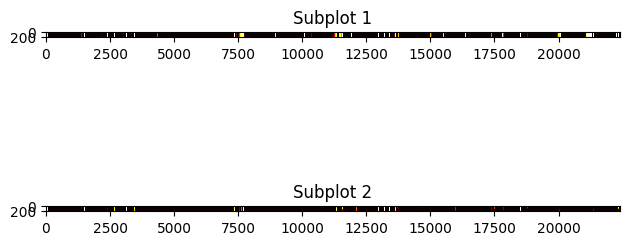

In [19]:
def reconstruct_matrix_super(matrix_target_shape, y, n=224, step_n=224, step_m=224):
    res = []
    i = 0
    while len(y) > matrix_target_shape[1]*(i+1):
        layer = y[matrix_target_shape[1]*i:matrix_target_shape[1]*(i+1):y.shape[2]//step_m]
        layer = np.concatenate(layer, axis=1)
        res.append(layer)
        i += n // step_n
    res = np.concatenate(res, axis=0)
    return res




rec1 = reconstruct_matrix_super(true_raw_shape, y_test)
rec2 = reconstruct_matrix_super(true_raw_shape, predicted_y)
plt.subplot(2, 1, 1)
plt.imshow(rec1, cmap='hot')
plt.title('Subplot 1')
plt.subplot(2, 1, 2)
plt.imshow(rec2, cmap='hot')
plt.title('Subplot 2')


plt.tight_layout()
plt.savefig("deeplabv3_mobilenet_v3_large")
plt.show()